# 광고 마케팅을 위한 Uplift Modeling 분석

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import sklearn
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [260]:
from pyuplift.datasets import load_hillstrom_email_marketing
df = load_hillstrom_email_marketing()
print(df)

{'DESCR': 'This dataset contains 64,000 customers who last purchased within twelve months. The customers were involved in an e-mail test. 1/3 were randomly chosen to receive an e-mail campaign featuring Mens merchandise. 1/3 were randomly chosen to receive an e-mail campaign featuring Womens merchandise. 1/3 were randomly chosen to not receive an e-mail campaign. During a period of two weeks following the e-mail campaign, results were tracked. Your job is to tell the world if the Mens or Womens e-mail campaign was successful.', 'data': array([[ 10.  , 142.44,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  6.  , 329.08,   1.  , ...,   0.  ,   0.  ,   1.  ],
       [  7.  , 180.65,   0.  , ...,   0.  ,   0.  ,   1.  ],
       ...,
       [  6.  ,  29.99,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  1.  , 552.94,   1.  , ...,   1.  ,   0.  ,   0.  ],
       [  1.  , 472.82,   0.  , ...,   0.  ,   0.  ,   1.  ]]), 'feature_names': ['recency', 'history', 'mens', 'womens', 'newbie', 'zip

<br>
Recency : 가장 최근 구매 달<br>
History_Segement : 작년에 지출 금액을 기준으로 카테고리화(집단 구분을 위함)<br>
History : 작년 실제 지출금액<br>
Mens: 1 = 작년에 남자 상품을 샀던 고객<br>
Womens: 1 = 작년에 여성 상품을 샀던 고객<br>
Zip_Code : Urban, Suburban, Rural 로 분류<br>
Newbie : 지난 12개월간 신규고객<br>
Channel: 결제 수단을 분류<br>

In [261]:
df['feature_names'] # 데이터 feature 이름들

['recency',
 'history',
 'mens',
 'womens',
 'newbie',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'history_segment_$0 - $100',
 'history_segment_$1,000 +',
 'history_segment_$100 - $200',
 'history_segment_$200 - $350',
 'history_segment_$350 - $500',
 'history_segment_$500 - $750',
 'history_segment_$750 - $1,000',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [262]:
df['data'] # feature에 상응하는 데이터

array([[ 10.  , 142.44,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  6.  , 329.08,   1.  , ...,   0.  ,   0.  ,   1.  ],
       [  7.  , 180.65,   0.  , ...,   0.  ,   0.  ,   1.  ],
       ...,
       [  6.  ,  29.99,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  1.  , 552.94,   1.  , ...,   1.  ,   0.  ,   0.  ],
       [  1.  , 472.82,   0.  , ...,   0.  ,   0.  ,   1.  ]])

In [263]:
new_df = pd.DataFrame(df['data'], columns = df['feature_names'])
new_df

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_$0 - $100,"history_segment_$1,000 +",history_segment_$100 - $200,history_segment_$200 - $350,history_segment_$350 - $500,history_segment_$500 - $750,"history_segment_$750 - $1,000",channel_Multichannel,channel_Phone,channel_Web
0,10.0,142.44,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6.0,329.08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.0,180.65,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,9.0,675.83,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2.0,45.34,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10.0,105.54,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
63996,5.0,38.91,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
63997,6.0,29.99,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
63998,1.0,552.94,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [264]:
df['treatment'] # 처치 0: 광고메일을 받지 않음 1: 남자 상품에 대한 광고메일을 받음 2: 여자 상품에 대한 광고메일을 받음

array([2, 0, 2, ..., 1, 2, 1], dtype=int64)

In [265]:
new_df['treatment'] = df['treatment']

In [266]:
df['target_visit'] # 1: 광고메일 후 2주안에 웹사이트를 방문한 고객

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [267]:
df['target_conversion'] # 1: 광고메일 후 2주안에 상품을 구매한 고객

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [268]:
df['target_spend'] # 1: 광고메일 후 2주안에 상품들을 실제 구매한 가격

array([0., 0., 0., ..., 0., 0., 0.])

In [269]:
data = np.concatenate((df['target_visit'].reshape(-1,1),df['target_conversion'].reshape(-1,1),df['target_spend'].reshape(-1,1)), axis =1)

In [270]:
target_df = pd.DataFrame(data = data, columns = ['target_visit','target_conversion','target_spend'])

In [271]:
target_df

,target_visit,target_conversion,target_spend
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
63995,0.0,0.0,0.0
63996,0.0,0.0,0.0
63997,0.0,0.0,0.0
63998,0.0,0.0,0.0


In [272]:
result = pd.concat([new_df,target_df],axis=1)

In [273]:
result

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_$0 - $100,"history_segment_$1,000 +",...,history_segment_$350 - $500,history_segment_$500 - $750,"history_segment_$750 - $1,000",channel_Multichannel,channel_Phone,channel_Web,treatment,target_visit,target_conversion,target_spend
0,10.0,142.44,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,0.0,0.0,0.0
1,6.0,329.08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
2,7.0,180.65,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0
3,9.0,675.83,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0
4,2.0,45.34,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10.0,105.54,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0
63996,5.0,38.91,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0
63997,6.0,29.99,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0
63998,1.0,552.94,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,2,0.0,0.0,0.0


# EDA

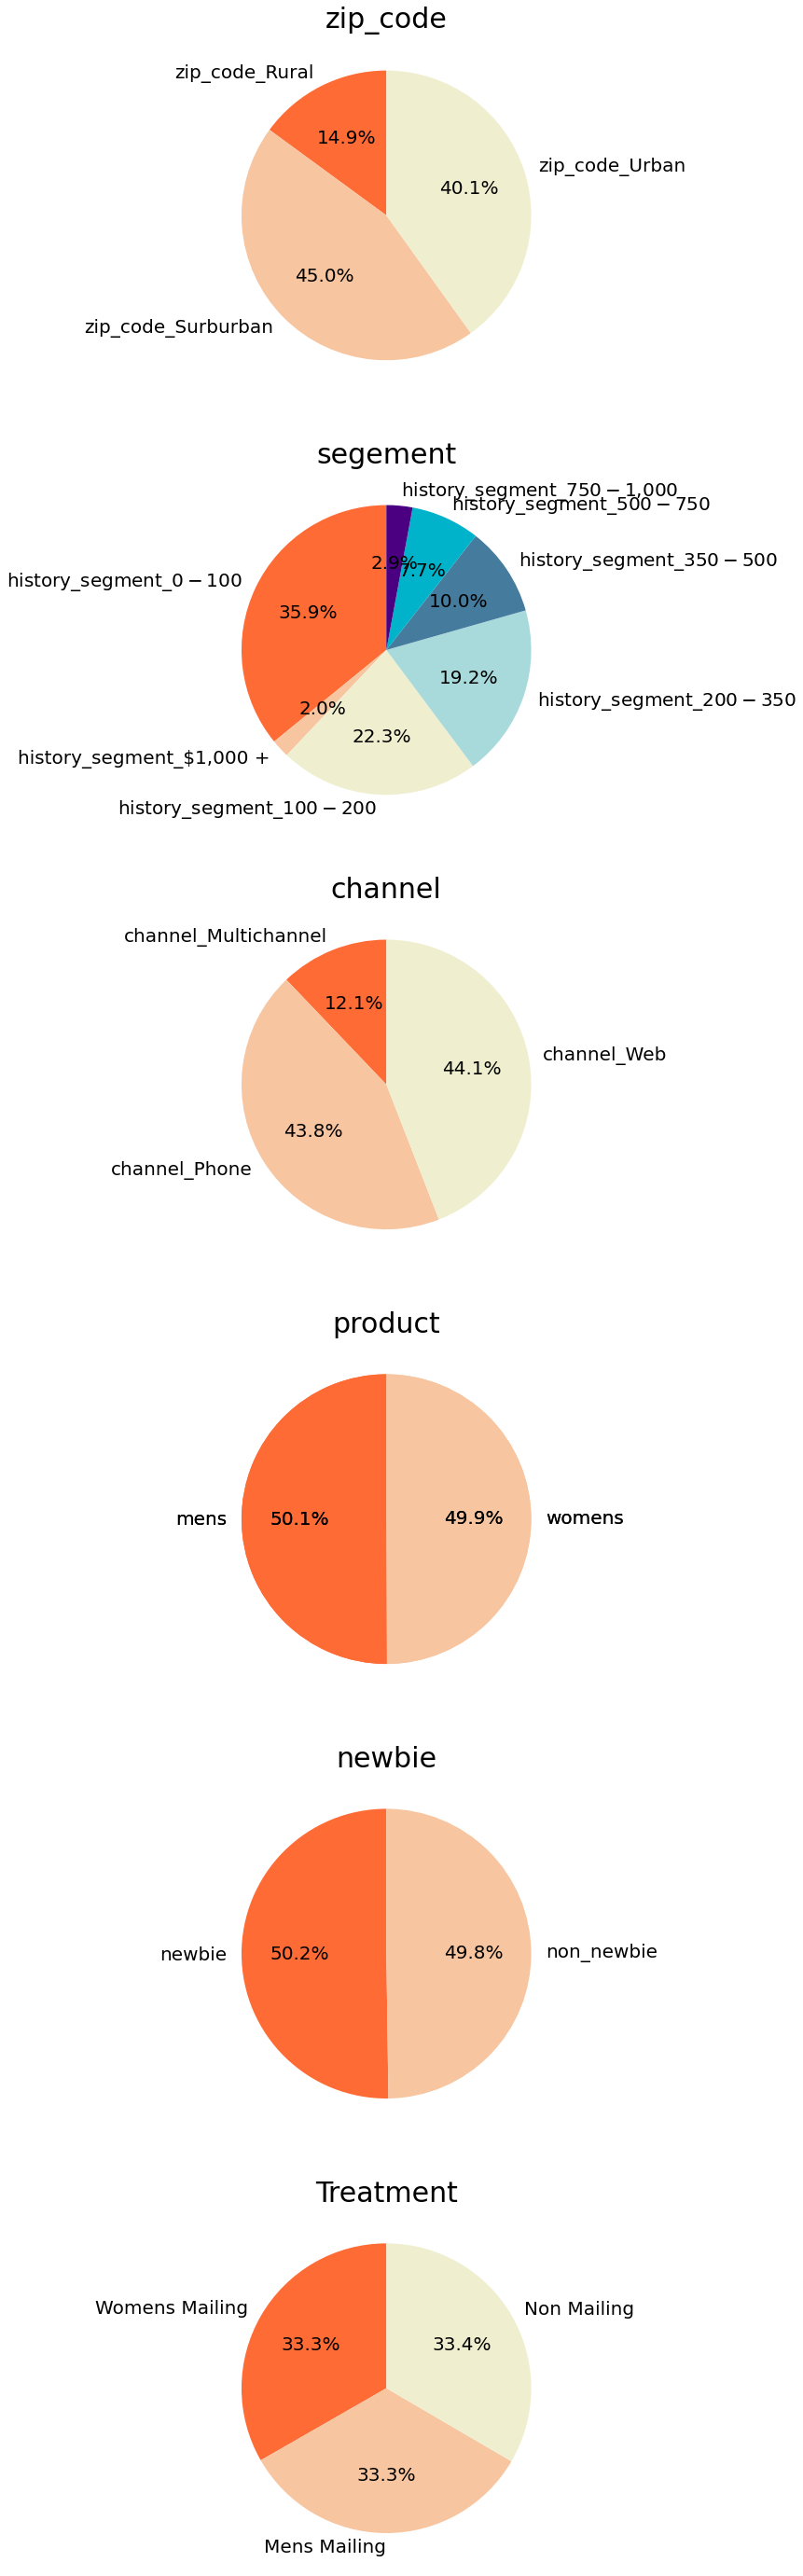

In [274]:
zip_code = ['zip_code_Rural','zip_code_Surburban','zip_code_Urban']
segment = ['history_segment_$0 - $100',
       'history_segment_$1,000 +', 'history_segment_$100 - $200',
       'history_segment_$200 - $350', 'history_segment_$350 - $500',
       'history_segment_$500 - $750', 'history_segment_$750 - $1,000']
channel = ['channel_Multichannel', 'channel_Phone', 'channel_Web']

product = ['mens', 'womens']
colors = ['#FF6B35','#F7C59F','#EFEFD0','#A8DADC','#457B9D','#00B2CA', 'indigo', 'hotpink']

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(figsize = (30, 50), ncols = 1, nrows = 6)

def num(li):
    temp = []
    for i in li:
        number = result[i].sum()/len(result[i])
        temp.append(number)
    return temp

ax1.pie(num(zip_code), labels = zip_code,shadow=False, startangle=90, autopct='%1.1f%%', colors =colors, textprops={'fontsize': 20})
ax1.set_title('zip_code', fontsize = 30)

ax2.pie(num(segment), labels = segment, shadow=False,  startangle=90, autopct='%1.1f%%', colors =colors,textprops={'fontsize': 20})
ax2.set_title('segement', fontsize = 30)

ax3.pie(num(channel), labels = channel, shadow=False,  startangle=90, autopct='%1.1f%%', colors =colors,textprops={'fontsize': 20})
ax3.set_title('channel', fontsize = 30)

ax4.pie(num(product), labels = product, shadow=False,  startangle=90, autopct='%1.1f%%', colors =colors,textprops={'fontsize': 20})
ax4.set_title('product', fontsize = 30)

ax4.pie(num(product), labels = product, shadow=False,  startangle=90, autopct='%1.1f%%', colors =colors,textprops={'fontsize': 20})
ax4.set_title('product', fontsize = 30)

temp = result['newbie'].sum()/len(result['newbie'])
li = [temp, 1-temp]

ax5.pie(li, labels = ['newbie','non_newbie'], shadow=False,  startangle=90, autopct='%1.1f%%', colors =colors,textprops={'fontsize': 20})
ax5.set_title('newbie',fontsize = 30)

li_t = []
for i in range(3):
    li_t.append(result['treatment'].value_counts()[i]/len(result['treatment']))

ax6.pie(li_t, labels = ['Womens Mailing', 'Mens Mailing', 'Non Mailing'], shadow=False,  startangle=90, autopct='%1.1f%%', colors =colors,textprops={'fontsize': 20})
ax6.set_title('Treatment',fontsize = 30)

plt.show()

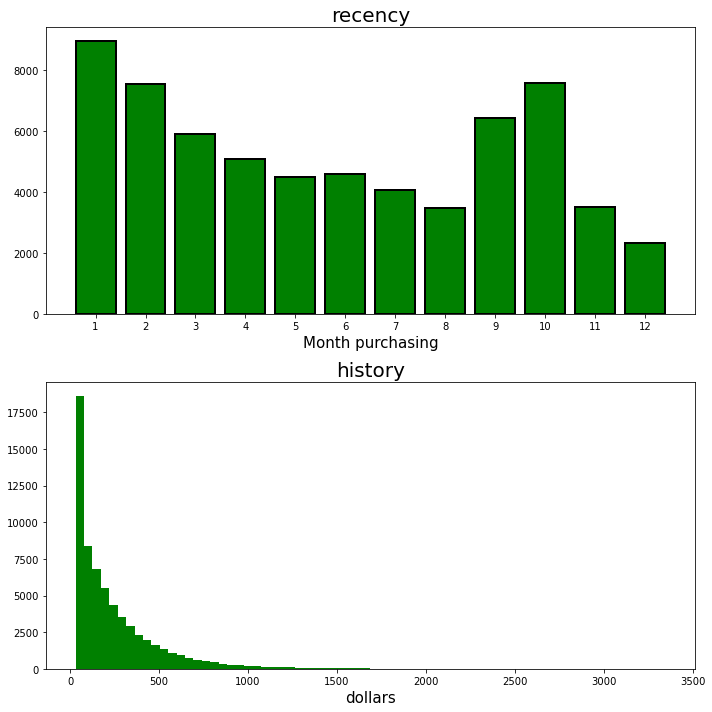

In [275]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,1,1)
ax.bar(result['recency'].value_counts().index,result['recency'].value_counts().values, color = 'green',edgecolor = 'black', linewidth = 2)
plt.xticks([i for i in range(1,13)])
plt.title('recency', fontsize = 20)
plt.xlabel('Month purchasing', fontsize = 15)

ax = fig.add_subplot(2,1,2)
ax.hist(result['history'], bins = 70, color ='green')
plt.title('history', fontsize = 20)
plt.xlabel('dollars', fontsize = 15)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='treatment', ylabel='target_conversion'>

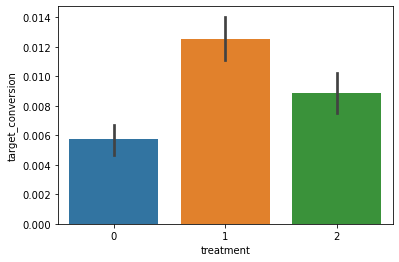

In [276]:
sns.barplot(x = 'treatment', y = 'target_conversion', data = result)

<AxesSubplot:xlabel='treatment', ylabel='target_visit'>

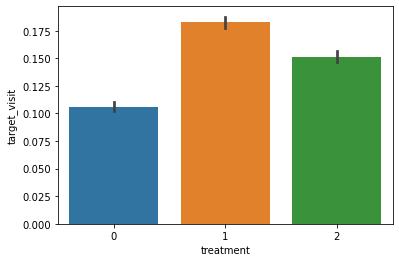

In [277]:
sns.barplot(x = 'treatment', y = 'target_visit', data = result)

<AxesSubplot:xlabel='treatment', ylabel='target_spend'>

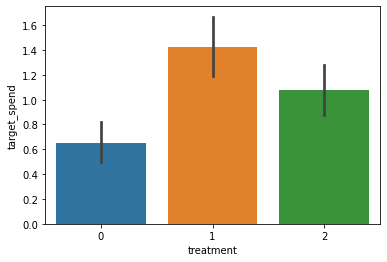

In [278]:
sns.barplot(x = 'treatment', y = 'target_spend', data = result)

In [279]:
# 참고:https://towardsdatascience.com/market-response-models-baf9f9913298
def calc_uplift(df):
    avg_order_value = 242  #result['history'].mean()
    
    #treatment를 받은 그룹 중 target_conversion을 한 사람들의 비율
    base_conv = df[df.treatment == 0]['target_conversion'].mean()
    male_conv = df[df.treatment == 1]['target_conversion'].mean()
    female_conv = df[df.treatment == 2]['target_conversion'].mean()
    
    # treatment == 0인 그룹과 1, 2인 그룹과의 uplift 계산
    male_conv_uplift = male_conv - base_conv
    female_conv_uplift = female_conv - base_conv
    
    #남성 광고, 여성 광고 받은 고객들의 주문수 uplift 계산
    male_order_uplift = male_conv_uplift * len(df[df.treatment == 1]['target_conversion'])
    female_order_uplift = female_conv_uplift * len(df[df.treatment == 2]['target_conversion'])
    
    #남성 광고, 여성 광고 받은 고객들의 주문 총 가격 uplift 계산
    male_rev_uplift = male_order_uplift * avg_order_value
    female_rev_uplift = female_order_uplift * avg_order_value
    
    
    print('Male Conversion Uplift: {0}%'.format(np.round(male_conv_uplift*100,2)))
    print('Male Order Uplift: {0}'.format(np.round(male_order_uplift,2)))
    print('Male Revenue Uplift: ${0}\n'.format(np.round(male_rev_uplift,2)))
          
    print('--------------------- \n')
    print('Female Conversion Uplift: {0}%'.format(np.round(female_conv_uplift*100,2)))
    print('Female Order Uplift: {0}'.format(np.round(female_order_uplift,2)))
    print('Female Revenue Uplift: ${0}'.format(np.round(female_rev_uplift,2)))

In [280]:
calc_uplift(result)

Male Conversion Uplift: 0.68%
Male Order Uplift: 144.99
Male Revenue Uplift: $35088.61

--------------------- 

Female Conversion Uplift: 0.31%
Female Order Uplift: 66.54
Female Revenue Uplift: $16101.76


# Uplift Score

In [281]:
new_result = result.copy()
new_result['uplift classification'] = 0

In [282]:
for i in range(len(new_result['treatment'])):
    if (new_result['treatment'][i] == 0 and new_result['target_conversion'][i] == 0):
        new_result['uplift classification'][i] = 0
    elif (new_result['treatment'][i] == 0 and new_result['target_conversion'][i] > 0):
        new_result['uplift classification'][i] = 1
    elif (new_result['treatment'][i] == 1 and new_result['target_conversion'][i] == 0):
        new_result['uplift classification'][i] = 2
    elif (new_result['treatment'][i] == 1 and new_result['target_conversion'][i] > 0):
        new_result['uplift classification'][i] = 3

<AxesSubplot:xlabel='uplift classification', ylabel='count'>

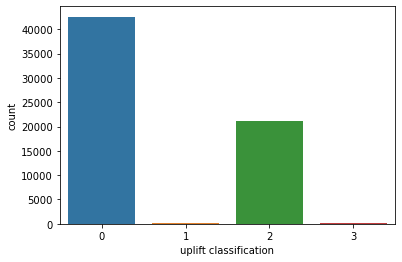

In [283]:
sns.countplot(x = 'uplift classification', data = new_result)

In [284]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

##### 지불금액 별로 분류되어있지만, KMeans를 배웠으니 써본다.

In [285]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(new_result[['history']])
new_result['history_cluster'] = kmeans.predict(new_result[['history']])
new_result = order_cluster('history_cluster', 'history',new_result,True)
df_model = new_result.drop(['treatment','target_conversion','target_spend','target_visit'],axis=1)
df_model = pd.get_dummies(df_model)

In [286]:
df_model['history_cluster'].value_counts()

0    32266
1    17955
2     9118
3     3743
4      918
Name: history_cluster, dtype: int64

In [287]:
X = df_model.drop(['uplift classification'],axis=1)
y = df_model['uplift classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
# xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
# class_probs = xgb_model.predict_proba(X_test)

In [252]:
params = {'eta':[0.01,0.1], 'max_depth':[3,5,8], 'max_leaf_nodes':[1,2,4],'subsample':[0.5, 0.7, 0.9]}
xgb_clf = xgb.XGBClassifier()
xgb_grid = GridSearchCV(estimator = xgb_clf, param_grid = params ,cv = 3, verbose=2, n_jobs = -1)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[02:04:44] WARNING: ..\src\learner.cc:541: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:04:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'eta': 0.1, 'max_depth': 3, 'max_leaf_nodes': 1, 'subsample': 0.7}


In [288]:
xgb_model = xgb.XGBClassifier(eta= 0.1 , max_leaf_nodes = 1, max_depth = 3, subsample = 0.7)
evals = [(X_test, y_test)]

xgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric ="mlogloss", eval_set = evals, verbose = True)

class_probs = xgb_model.predict_proba(X_test)

[02:10:16] WARNING: ..\src\learner.cc:541: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.30849
[1]	validation_0-mlogloss:1.24215
[2]	validation_0-mlogloss:1.18486
[3]	validation_0-mlogloss:1.13522
[4]	validation_0-mlogloss:1.09156
[5]	validation_0-mlogloss:1.05339
[6]	validation_0-mlogloss:1.01938
[7]	validation_0-mlogloss:0.98913
[8]	validation_0-mlogloss:0.96205
[9]	validation_0-mlogloss:0.93784
[10]	validation_0-mlogloss:0.91610
[11]	validation_0-mlogloss:0.89641
[12]	validation_0-mlogloss:0.87859
[13]	validation_0-mlogloss:0.86245
[14]	validation_0-mlogloss:0.84777
[15]	validation_0-mlogloss:0.83440
[16]	validation_0-mlogloss:0.82225
[17]	validation_0-mlogloss:0.81111
[18]	validation_0-mlogloss:0.80085
[19]	valida

In [289]:
class_probs[0]

array([0.6589309 , 0.00355084, 0.33319944, 0.00431881], dtype=float32)

In [290]:
overall_proba = xgb_model.predict_proba(df_model.drop(['uplift classification'],axis=1))
#4가지 종류의 uplift score 구분
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]
#uplift score 계산
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')

new_result['uplift_score'] = df_model['uplift_score']

In [291]:
def calc_uplift(df):
    avg_order_value = 242
    
    #treatment를 받은 그룹 중 target_conversion을 한 사람들의 비율
    base_conv = df[df.treatment == 0]['target_conversion'].mean()
    total_conv = df[df.treatment > 0]['target_conversion'].mean()

    # treatment == 0인 그룹과 그렇지 않은 그룹과의 uplift 계산
    total_conv_uplift = total_conv - base_conv

    #광고 받은 고객들의 주문수 uplift 계산
    total_order_uplift = total_conv_uplift * len(df[df.treatment > 0]['target_conversion'])
 
    #광고 받은 고객들의 주문 총 가격 uplift 계산
    total_rev_uplift = total_order_uplift * avg_order_value

    print('total Conversion Uplift: {0}%'.format(np.round(total_conv_uplift*100,2)))
    print('total Order Uplift: {0}'.format(np.round(total_order_uplift,2)))
    print('total Revenue Uplift: ${0}\n'.format(np.round(total_rev_uplift,2)))

상위 25퍼센트 uplift score를 이용하여 계산

In [292]:
df_data_lift = new_result.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[df_data_lift.uplift_score > uplift_q_75].reset_index(drop=True)
calc_uplift(df_data_lift)

total Conversion Uplift: 0.77%
total Order Uplift: 78.79
total Revenue Uplift: $19067.62



하위 25퍼센트 uplift score를 이용하여 계산

In [294]:
df_data_lift = new_result.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.25)
df_data_lift = df_data_lift[df_data_lift.uplift_score < uplift_q_75].reset_index(drop=True)
calc_uplift(df_data_lift)

total Conversion Uplift: 0.23%
total Order Uplift: 25.92
total Revenue Uplift: $6272.82

